In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from keras.applications import vgg16
from numpy.testing import assert_allclose
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [31]:
def rr_data(imgp,img_classes,dims,limit): #read and resize
    data = []
    labels = []
    f=0
    plt.figure(1)
    for classes in img_classes:
        print('Loading data:' + classes)
        image_path=imgp+classes+'/'
        p=os.listdir(image_path)
        num_img=len(p)
        if limit>0:
            num_img=limit
        for i in range(num_img):
            current_path=image_path+p[i]
            image = cv2.imread(image_path+p[i])
            image = cv2.resize(image,dims)
            data.append(image)
            labels.append(classes)
        
        plt.subplot(2, 2, f+1)
        plt.title(classes)
        plt.imshow(image)
        plt.axis('off')
        f=f+1

   
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    
    return data, labels

In [32]:
def normalize_data(data):
    N=len(data)
    S=np.zeros(data[0].shape)
    for i in range(N):
        S=S+1/N*data[i]
    return data-S, S

In [33]:
def report_matrix(model, testX, testY, batch_size, target_names, cmap):
    #model, testX, testY, batch_size
    #target_names list of classes
    pred = model.predict(testX, batch_size=batch_size)
    print("Classification Report")
    print(classification_report(testY.argmax(axis=1),pred.argmax(axis=1), target_names=target_names))
    cm=confusion_matrix(testY.argmax(axis=1), pred.argmax(axis=1))
    df_cm = pd.DataFrame(cm, columns=img_classes, index = img_classes)
    sns.heatmap(df_cm,annot=True,cmap=cmap, fmt='g')
    plt.title('Confusion Matrix')
    return None

In [34]:
siz=2 #resolution
dims=(32*siz,24*siz)
img_path="C:/Data/blood/dataset2-master/images/TRAIN/"
img_classes=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']
max_per_class=0  
batch_size=32

#dims=(16*siz,16*siz)
#img_path="C:/Data/animals/"
#img_classes=['cat','dog','panda']

Loading data:EOSINOPHIL
Loading data:LYMPHOCYTE
Loading data:MONOCYTE
Loading data:NEUTROPHIL
Total number of examples: 9957


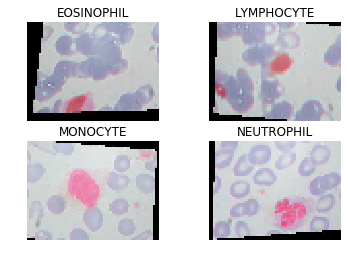

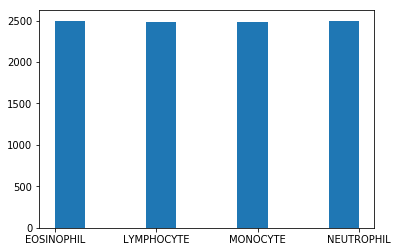

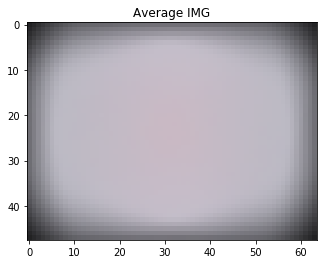

In [35]:
data, labels_raw=rr_data(imgp=img_path,img_classes=img_classes,dims=dims,limit=max_per_class)
print('Total number of examples:', len(data))

plt.figure(5)
plt.hist(labels_raw)

lb = LabelBinarizer()
labels = lb.fit_transform(labels_raw)


plt.figure(6)
data, S = normalize_data(data) #S is background
plt.imshow(S)

plt.title('Average IMG')

bck=S


(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.10, random_state=7)



The set is balanced with ~2500 samples of each class. Note that even we have roughly the same number of augmented images per class. The augmented set was obtained using an imbalanced set of raw data

<BarContainer object of 4 artists>

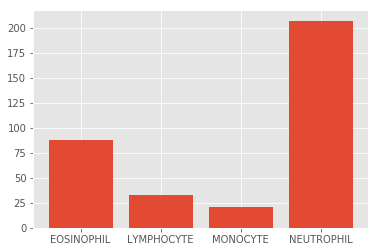

In [60]:
unique, counts = np.unique(labels_raw, return_counts=True)
counts


original=[88, 33, 21, 207]
plt.bar(img_classes,original)

Raw data is imbalanced with only 21 samples for Monocyte and 200 for Neutrophil.

In [ ]:
LEARNING_RATE=0.03
EPOCHS = 20
bn_momentum=0.9
 
drop_out=True
dp_value=0.5    
    
model = Sequential()
chanDim=-1

model.add(Conv2D(32, (7, 7), padding="valid", input_shape=data[0].shape)) 
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

if drop_out:
    model.add(Dropout(dp_value))
        
model.add(Conv2D(64, (4, 4), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim, momentum=bn_momentum))
model.add(Conv2D(64, (4, 4), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim, momentum=bn_momentum))
model.add(MaxPooling2D(pool_size=(2, 2)))

if drop_out:
    model.add(Dropout(dp_value))
        
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim, momentum=bn_momentum))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim, momentum=bn_momentum))
model.add(MaxPooling2D(pool_size=(2, 2)))

if drop_out:
    model.add(Dropout(dp_value))

model.add(Flatten())

model.add(Dense(64))
model.add(Dense(32))
model.add(Activation("relu"))
model.add(BatchNormalization(momentum=bn_momentum))

if drop_out:
    model.add(Dropout(0.2))
    
#softmax classifier

model.add(Dense(len(img_classes)))
model.add(Activation("softmax"))


opt=Adam(lr=LEARNING_RATE, beta_1=0.90, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)

model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model.build()
model.summary()

In [42]:
filepath='bloodcnn40.h5'
model.save(filepath)

In [43]:
#TRAIN
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

H = model.fit(trainX, trainY, validation_data=(testX, testY),epochs=EPOCHS, batch_size=batch_size, callbacks=callbacks_list)

Train on 8961 samples, validate on 996 samples
Epoch 1/20
8961/8961 [==============================] - 242s 27ms/step - loss: 1.1376 - acc: 0.4724 - val_loss: 0.8415 - val_acc: 0.6044

Epoch 00001: loss improved from inf to 1.13763, saving model to bloodcnn40.h5
Epoch 2/20
8961/8961 [==============================] - 249s 28ms/step - loss: 0.7689 - acc: 0.6466 - val_loss: 0.6410 - val_acc: 0.6918

Epoch 00002: loss improved from 1.13763 to 0.76885, saving model to bloodcnn40.h5
Epoch 3/20
8961/8961 [==============================] - 236s 26ms/step - loss: 0.6261 - acc: 0.7244 - val_loss: 0.6522 - val_acc: 0.7219

Epoch 00003: loss improved from 0.76885 to 0.62608, saving model to bloodcnn40.h5
Epoch 4/20
8961/8961 [==============================] - 239s 27ms/step - loss: 0.5368 - acc: 0.7812 - val_loss: 0.3920 - val_acc: 0.8343

Epoch 00004: loss improved from 0.62608 to 0.53685, saving model to bloodcnn40.h5
Epoch 5/20
8961/8961 [==============================] - 234s 26ms/step - loss

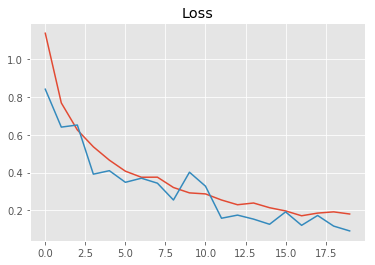

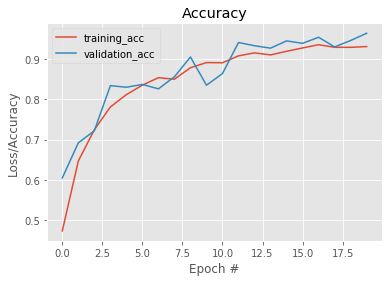

In [44]:
 # plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(3)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.figure(4)
plt.plot(N, H.history["acc"], label="training_acc")
plt.plot(N, H.history["val_acc"], label="validation_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
#Only use to continute training.

new_model = load_model(filepath)

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
new_model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=batch_size, callbacks=callbacks_list)


In [45]:
filepath='bloodcnn40.h5'
new_model = load_model(filepath)


In [ ]:
#generate CNN architecture

import os
import pydot
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils import plot_model
plt.figure(10)
plot_model(new_model, to_file='model_arch.png', show_shapes=True, show_layer_names=False)



Training set classification report
Classification Report
              precision    recall  f1-score   support

  EOSINOPHIL       0.98      0.89      0.93      2254
  LYMPHOCYTE       1.00      1.00      1.00      2223
    MONOCYTE       0.99      1.00      1.00      2235
  NEUTROPHIL       0.90      0.98      0.94      2249

   micro avg       0.97      0.97      0.97      8961
   macro avg       0.97      0.97      0.97      8961
weighted avg       0.97      0.97      0.96      8961



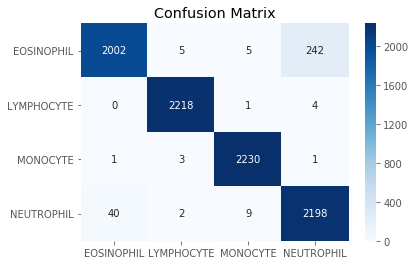

In [47]:
print('Training set classification report')
report_matrix(model=new_model, testX=trainX, testY=trainY, batch_size=batch_size, target_names=lb.classes_,cmap='Blues')

97% Training set accuracy. Mostly NEUTROPHIL cells are wrongly classified as EOSINOPHIL.

Development set classification report
Classification Report
              precision    recall  f1-score   support

  EOSINOPHIL       0.97      0.85      0.91       243
  LYMPHOCYTE       0.99      1.00      1.00       260
    MONOCYTE       0.99      1.00      0.99       243
  NEUTROPHIL       0.87      0.97      0.92       250

   micro avg       0.95      0.95      0.95       996
   macro avg       0.96      0.95      0.95       996
weighted avg       0.96      0.95      0.95       996



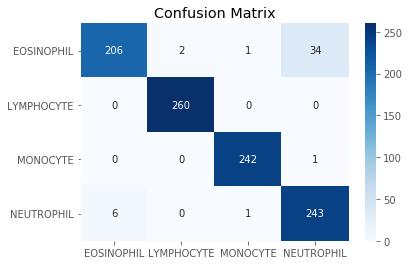

In [49]:
print('Development set classification report')
report_matrix(model=new_model, testX=testX, testY=testY, batch_size=batch_size, target_names=lb.classes_,cmap='Blues')

97% Development set accuracy. Again, mostly NEUTROPHIL cells are wrongly classified as EOSINOPHIL.

Load up images the model have never seen before.

In [66]:
siz=2 #resolution
dims=(32*siz,24*siz)
img_path1="C:/Data/blood/dataset2-master/images/TEST/"
img_classes=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']


Loading data:EOSINOPHIL
Loading data:LYMPHOCYTE
Loading data:MONOCYTE
Loading data:NEUTROPHIL
Total number of test examples: 2487


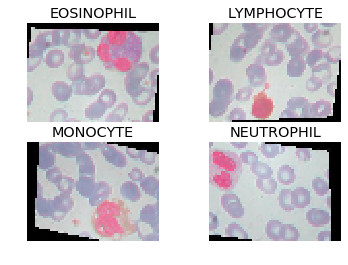

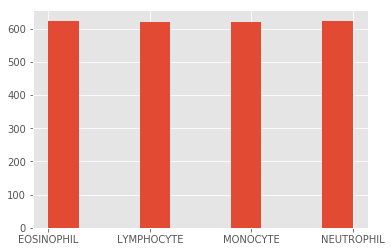

In [67]:
test_data, test_labels_raw=rr_data(imgp=img_path1,img_classes=img_classes,dims=dims,limit=0)
print('Total number of test examples:', len(test_data))

plt.figure(7)
plt.hist(test_labels_raw)

test_lb = LabelBinarizer()
test_labels = test_lb.fit_transform(test_labels_raw)

test_data=test_data-S #remove background
#test_data, S = normalize_data(test_data)

Classification Report
              precision    recall  f1-score   support

  EOSINOPHIL       0.87      0.65      0.74       623
  LYMPHOCYTE       0.99      1.00      1.00       620
    MONOCYTE       0.98      0.84      0.90       620
  NEUTROPHIL       0.64      0.89      0.74       624

   micro avg       0.84      0.84      0.84      2487
   macro avg       0.87      0.84      0.85      2487
weighted avg       0.87      0.84      0.85      2487



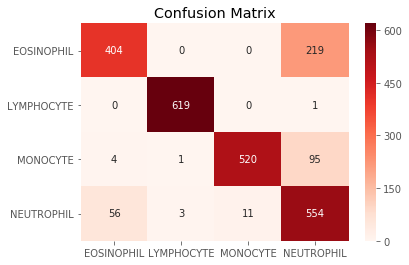

In [68]:
report_matrix(model=new_model, testX=test_data, testY=test_labels, batch_size=batch_size, target_names=test_lb.classes_,cmap='Reds')

Accuracy: 87%
Some EOSIONOPHILS and MONOCYTES are incorreclty predicted as NEUTROPHILS. Due to imbalance of the raw set (200N, 80E, 20L, 30M) there is a bias towards the majority (N) class. 
LYMPHOCYTES are almost perfectly predicted due to being very different from other 3 classes. Their cell lacks any distingushing structure, its just an isotropic blob.